In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

df = pd.read_csv("meteo_data.csv")
df.index = pd.to_datetime(df.DATE)
del df['DATE']

# filter the columns by only the required_columns
required_cols = ['SOLAR_RADIATION', 'WIND_SPEED', 'PRECIPITATION','LEAF_WETNESS', 'HC_AIR_TEMPERATURE', 'HC_RELATIVE_HUMIDITY', 'DEW_POINT']
df = df[required_cols]
df
# temp = df['HC_AIR_TEMPERATURE']

# # Создание массива индексов для оси X
# indices = np.arange(len(temp))

# plt.figure(figsize=(10, 6))
# plt.plot(indices, temp, label='Температура воздуха', color='blue')

# # Настройка графика
# plt.xlabel('Индекс')
# plt.ylabel('Значение')
# plt.legend()

# # Показать график
# plt.show()

,SOLAR_RADIATION,WIND_SPEED,PRECIPITATION,LEAF_WETNESS,HC_AIR_TEMPERATURE,HC_RELATIVE_HUMIDITY,DEW_POINT
DATE,,,,,,,
2022-10-26 22:00:00,0.0,0.9,0.6,15.0,13.39,0.00,0.0
2022-10-26 23:00:00,0.0,1.6,0.4,60.0,13.52,7.24,0.0
2022-10-27 00:00:00,0.0,1.1,0.0,60.0,13.64,0.00,0.0
2022-10-27 01:00:00,0.0,1.0,0.0,60.0,13.59,0.00,0.0
2022-10-27 02:00:00,0.0,1.8,0.4,60.0,13.63,0.00,0.0
...,...,...,...,...,...,...,...
2024-05-22 17:00:00,447.0,3.1,0.0,0.0,27.16,0.00,0.0
2024-05-22 18:00:00,266.0,2.9,0.0,0.0,26.46,0.00,0.0
2024-05-22 19:00:00,99.0,1.7,0.0,0.0,25.16,0.00,0.0


In [15]:
#df_final = df.resample('D').mean()
df_final = df
df_final

,SOLAR_RADIATION,WIND_SPEED,PRECIPITATION,LEAF_WETNESS,HC_AIR_TEMPERATURE,HC_RELATIVE_HUMIDITY,DEW_POINT
DATE,,,,,,,
2022-10-26 22:00:00,0.0,0.9,0.6,15.0,13.39,0.00,0.0
2022-10-26 23:00:00,0.0,1.6,0.4,60.0,13.52,7.24,0.0
2022-10-27 00:00:00,0.0,1.1,0.0,60.0,13.64,0.00,0.0
2022-10-27 01:00:00,0.0,1.0,0.0,60.0,13.59,0.00,0.0
2022-10-27 02:00:00,0.0,1.8,0.4,60.0,13.63,0.00,0.0
...,...,...,...,...,...,...,...
2024-05-22 17:00:00,447.0,3.1,0.0,0.0,27.16,0.00,0.0
2024-05-22 18:00:00,266.0,2.9,0.0,0.0,26.46,0.00,0.0
2024-05-22 19:00:00,99.0,1.7,0.0,0.0,25.16,0.00,0.0


In [16]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_final)

# Define sequence length and features
sequence_length = 10  # Number of time steps in each sequence
num_features = len(df_final.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i+sequence_length]
    label = scaled_data[i+sequence_length][0]  # 'HC_AIR_TEMPERATURE' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

Train X shape: (11002, 10, 7)
Train Y shape: (11002,)
Test X shape: (2751, 10, 7)
Test Y shape: (2751,)


In [17]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# # Create the LSTM model
# model = Sequential()

# # Add LSTM layers with dropout
# model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units=64, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units=32, return_sequences=False))
# model.add(Dropout(0.2))

# # Add a dense output layer
# model.add(Dense(units=1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\Счастливый Наиль\PycharmProjects\meteoApp\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 10, 128)             │          69,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,489 (513.63 KB)

 Trainable params: 131,489 (513.63 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Create the LSTM model
model = Sequential()

# Add LSTM layers with dropout and L2 regularization
model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))

model.add(LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))

model.add(LSTM(units=32, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))

# Add a dense output layer
model.add(Dense(units=1, kernel_regularizer=l2(0.01)))

# Compile the model
model.compile(optimizer='adam', loss='huber')

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Fit the model with validation data and callbacks
history = model.fit(train_x, train_y, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
model.evaluate(test_x, test_y)

Epoch 1/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 1.0427 - val_loss: 0.0155
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0251 - val_loss: 0.0145
Epoch 3/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0228 - val_loss: 0.0065
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0227 - val_loss: 0.0117
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0217 - val_loss: 0.0105
Epoch 6/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0214 - val_loss: 0.0103
Epoch 7/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0212 - val_loss: 0.0054
Epoch 8/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0215 - val_loss: 0.0061
Epoch 9/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0212 - val_loss: 0.0066
Epoch 10/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0209 - val_loss: 0.0182
Epoch 11/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0205 - val_loss: 0.0103
Epoch 12/100
276/276 ━━━━━━━━

0.02690509520471096

In [20]:
# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('best_model.keras')
test_loss = best_model.evaluate(test_x, test_y)
print("Test Loss:", test_loss)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0149
Test Loss: 0.02690509520471096


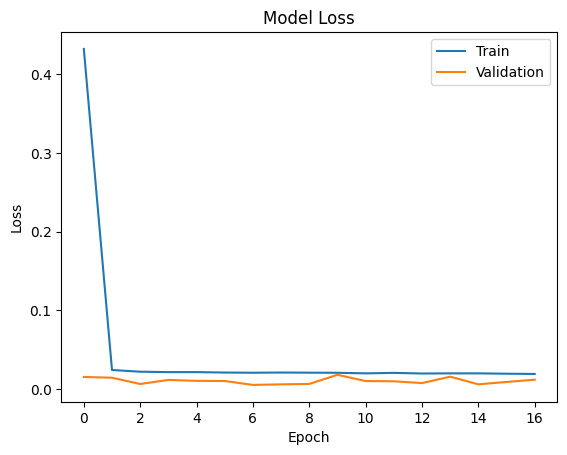

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming you have trained the model and have the 'best_model' object
# Also, 'test_x' and 'test_y' should be available

# Predict temperatures using the trained model
predictions = best_model.predict(test_x)

# Calculate evaluation metrics
mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R2:", r2)

86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Mean Absolute Error (MAE): 0.14171304864268244
Mean Squared Error (MSE): 0.050885566904627325
Root Mean Squared Error (RMSE): 0.2255782944004749
R2: 0.057411796187275876


In [24]:
# y_true values
test_y_copies = np.repeat(test_y.reshape(-1, 1), test_x.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(test_y_copies)[:,2]

# predicted values
prediction = best_model.predict(test_x)
prediction_copies = np.repeat(prediction, len(df_final.columns), axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,2]

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


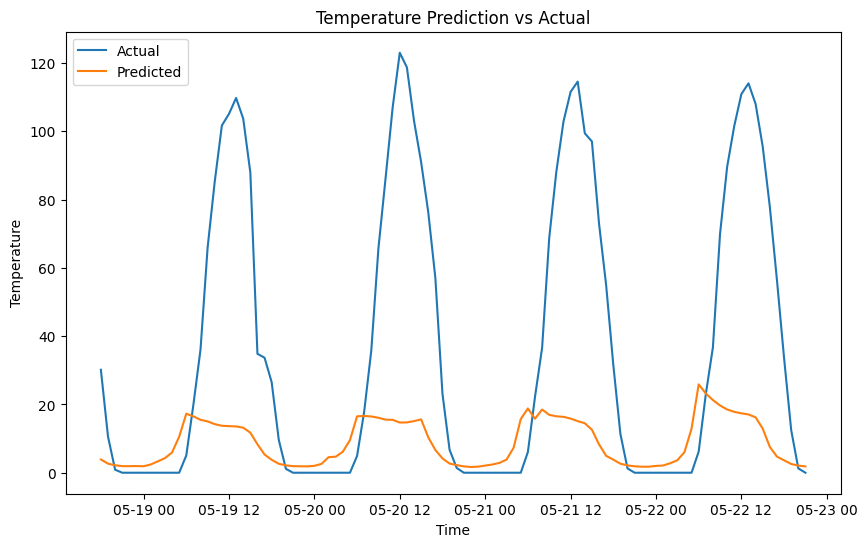

In [25]:
# Plotting predicted and actual temperatures
plt.figure(figsize=(10, 6))
plt.plot(df_final.index[-100:], true_temp[-100:], label='Actual')
plt.plot(df_final.index[-100:], predicted_temp[-100:], label='Predicted')
plt.title('Temperature Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [26]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

In [ ]:
X_train1, y_train1 = X1[:10500], y1[:10500]
X_val1, y_val1 = X1[10500:12000], y1[10500:12000]
X_test1, y_test1 = X1[12000:], y1[12000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

In [6]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2, activation='relu'))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           2,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257 (8.82 KB)

 Trainable params: 2,257 (8.82 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
cp2 = ModelCheckpoint('model2/model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [8]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 180.3343 - root_mean_squared_error: 13.3167 - val_loss: 8.4322 - val_root_mean_squared_error: 2.9024
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.6023 - root_mean_squared_error: 3.6614 - val_loss: 5.0638 - val_root_mean_squared_error: 2.2502
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2135 - root_mean_squared_error: 2.4919 - val_loss: 4.1026 - val_root_mean_squared_error: 2.0255
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7218 - root_mean_squared_error: 2.1723 - val_loss: 3.3490 - val_root_mean_squared_error: 1.8301
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7668 - root_mean_squared_error: 1.9393 - val_loss: 2.5782 - val_root_mean_squared_error: 1.6059
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8459 - root_mean_squared_error: 1.6862 - val_loss: 2.0010 - val_root_mean_squared_error: 1.4149
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/s

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


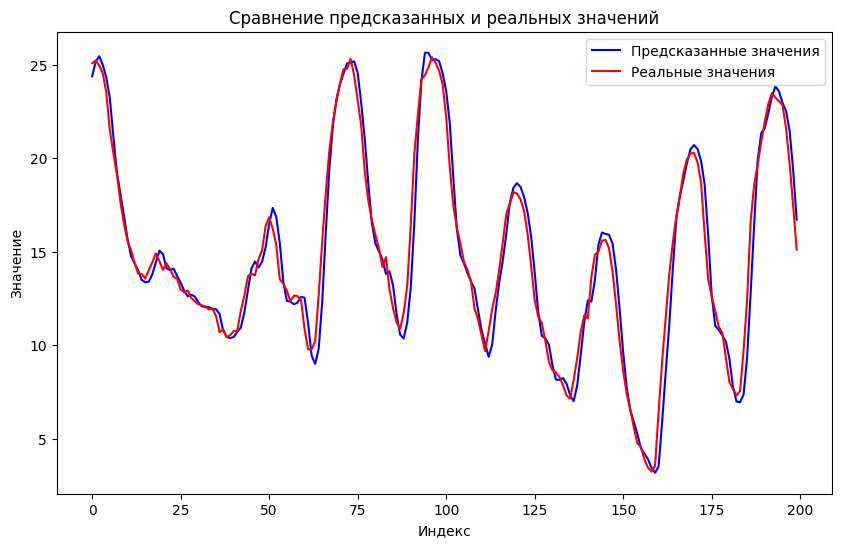

In [12]:
# Предсказание на тестовом наборе данных
y_pred1 = model2.predict(X_test1)

# Построение графика предсказанных и реальных значений
plt.figure(figsize=(10, 6))
plt.plot(y_pred1[700:900], label='Предсказанные значения', color='blue')
plt.plot(y_test1[700:900], label='Реальные значения', color='red')
plt.title('Сравнение предсказанных и реальных значений')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [13]:
mae = mean_absolute_error(y_test1, y_pred1)
mse = mean_squared_error(y_test1, y_pred1)
rmse = np.sqrt(mse)
r2 = r2_score(y_test1, y_pred1)

print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя квадратичная ошибка (MSE):", mse)
print("Корень из среднеквадратичной ошибки (RMSE):", rmse)
print("Коэффициент детерминации (R^2):", r2)

Средняя абсолютная ошибка (MAE): 0.9528313609639856
Средняя квадратичная ошибка (MSE): 2.2984565831197186
Корень из среднеквадратичной ошибки (RMSE): 1.5160661539391078
Коэффициент детерминации (R^2): 0.9388745421476372
